# ANN and others

### Notebook
- [Github](https://github.com/bentrevett/pytorch-image-classification?tab=readme-ov-file)
- [DATAI](https://www.kaggle.com/code/kanncaa1/pytorch-tutorial-for-deep-learning-lovers)

In [ ]:
%pip install torch 
%pip install torchvision
%pip install sklearn
# sklearn apperantly depricated?
%pip install scikit-learn
%pip install tqdm


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

# correct scikit-learn and tqdm imports
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

import copy
import random

## Reproducability

In [2]:
# reproducability
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Data

In [3]:
# getting data
root = '.data'
train_data = datasets.MNIST(root=root,
                            train=True,
                            download=True)

In [4]:
# data norm
mean =  train_data.data.float().mean() /255
std = train_data.data.float().std() /255
print(f"ds mean: {mean}, \nds std: {std}")

ds mean: 0.13066047430038452, 
ds std: 0.30810779333114624


In [5]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[mean], std=[std])
                              ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[mean], std=[std])])

In [6]:
train_data = datasets.MNIST(root = root,
                            train=True,
                            download=True,
                            transform = train_transforms)
test_data = datasets.MNIST(root=root,
                            train=False,
                            download=True,
                            transform=test_transforms)

print(f"train: {train_data}, test: {test_data}")

train: Dataset MNIST
    Number of datapoints: 60000
    Root location: .data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=(0,))
               RandomCrop(size=(28, 28), padding=2)
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           ), test: Dataset MNIST
    Number of datapoints: 10000
    Root location: .data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )


In [7]:
def plot_images(images):
    n_images= len(images)
    cols = int(np.sqrt(n_images))
    rows = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(n_images):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28,28).cpu().numpy()) #, cmap='bone' => gray img
        ax.axis('off')

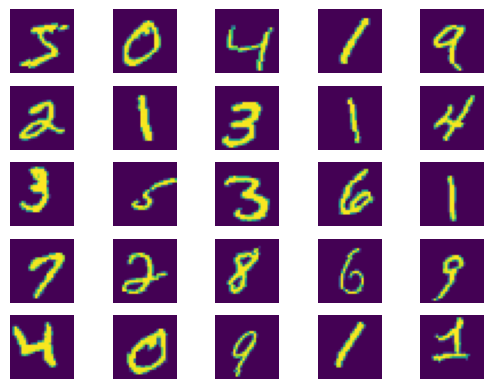

In [8]:
NO_images = 25
images = [image for image, label in [train_data[i] for i in range(NO_images)]]
plot_images(images)

In [9]:
valid_rat = 0.9
train_exm = int(len(train_data)*valid_rat)
valid_exm = len(train_data) - train_exm

train_data, valid_data = data.random_split(train_data, [train_exm, valid_exm])

In [10]:
print(f"train data: {len(train_data)}, \nvalidation data: {len(valid_data)}, \ntest data: {len(test_data)}")

train data: 54000, 
validation data: 6000, 
test data: 10000


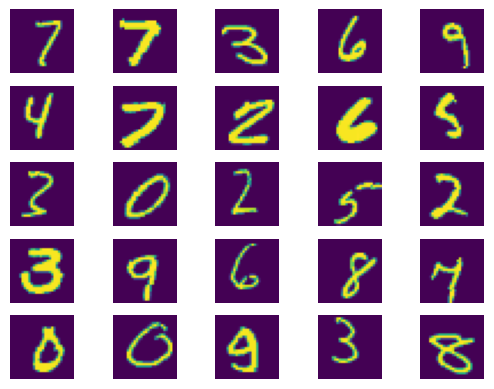

In [11]:
n_img = 25
images = [image for image, label in [valid_data[i] for i in range(n_img)]]
plot_images(images)

In [12]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [13]:
# Data loaders => batches + shuffle
batch_size = 64
train_dl = data.DataLoader(train_data,
                           shuffle=True,
                           batch_size = batch_size)
valid_dl = data.DataLoader(valid_data,
                           batch_size=batch_size)
test_dl = data.DataLoader(test_data,
                          batch_size=batch_size)

## Model

In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        # x = [batch_size, h, w]
        x = x.view(x.shape[0], -1) #flatten h,w

        h1 = f.relu(self.input_fc(x))
        h2 = f.relu(self.hidden_fc(h1))
        y_pred = f.relu(self.output_fc(h2))

        return y_pred, h2

In [15]:
input_dim = 28 * 28
output_dim = 10
model = MLP(input_dim, output_dim)

In [16]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) #numel() => number of elements
print(f"trainable params: {count_param(model):,}")

trainable params: 222,360


In [17]:
optimizer = optim.Adam(model.parameters())

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
model = model.to(device)
criterion = criterion.to(device)

In [21]:
def calc_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True) # y[batch_size, class] => argmax(1)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0] #accuracy/batch size
    return acc

In [22]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x,y) in tqdm(iterator, desc="Training", leave=False):
        # desc = description, leave= false => don't vanish

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)
        acc = calc_accuracy(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for (x,y) in tqdm(iterator, leave=False, desc="Evaluating"):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calc_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [24]:
epochs = 10

best_val_loss = float('inf') #infinity => first loss always < initial
for epoch in range(epochs):

    train_loss, train_acc = train(model, train_dl, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_dl, criterion, device)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model1.pt')

    
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain loss: {train_loss:.3f} | Train acc: {train_acc*100:.2f}%")
    print(f"\tValid loss: {val_loss:.3f} | Valid acc: {val_acc*100:.2f}%")

Epoch: 01
	Train loss: 1.061 | Train acc: 68.12%
	Valid loss: 0.853 | Valid acc: 75.40%


Epoch: 02
	Train loss: 0.854 | Train acc: 75.00%
	Valid loss: 0.828 | Valid acc: 76.11%


Epoch: 03
	Train loss: 0.824 | Train acc: 75.88%
	Valid loss: 0.795 | Valid acc: 76.92%


Epoch: 04
	Train loss: 0.805 | Train acc: 76.42%
	Valid loss: 0.787 | Valid acc: 77.58%


Epoch: 05
	Train loss: 0.786 | Train acc: 77.07%
	Valid loss: 0.571 | Valid acc: 86.73%


Epoch: 06
	Train loss: 0.559 | Train acc: 86.61%
	Valid loss: 0.549 | Valid acc: 87.33%


Epoch: 07
	Train loss: 0.547 | Train acc: 87.14%
	Valid loss: 0.539 | Valid acc: 87.63%


Epoch: 08
	Train loss: 0.536 | Train acc: 87.50%
	Valid loss: 0.533 | Valid acc: 87.86%


Epoch: 09
	Train loss: 0.533 | Train acc: 87.55%
	Valid loss: 0.536 | Valid acc: 87.72%


Epoch: 10
	Train loss: 0.528 | Train acc: 87.71%
	Valid loss: 0.534 | Valid acc: 87.63%


In [25]:
model.load_state_dict(torch.load('model1.pt'))
test_loss, test_acc = evaluate(model, test_dl, criterion, device)
print(f"test acc: {test_acc*100: .2f}%")

test acc:  88.57%


In [26]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = f.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [27]:
images, labels, probs = get_predictions(model, test_dl, device)
pred_lbl = torch.argmax(probs, 1)

In [28]:
def plot_confusion_matrix(labels, pred_lbl):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    cm = metrics.confusion_matrix(labels, pred_lbl)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

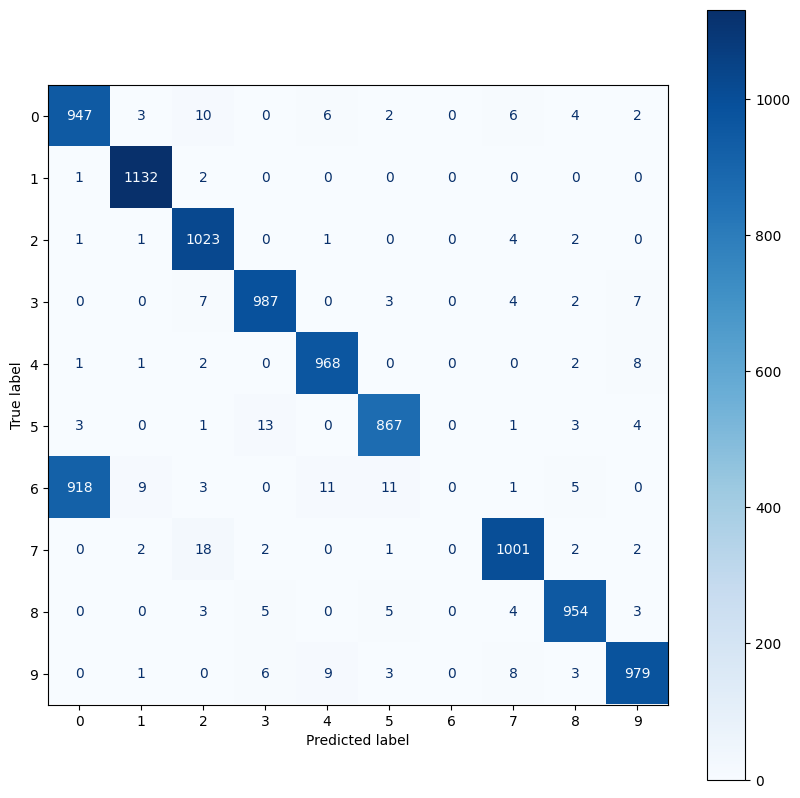

In [29]:
plot_confusion_matrix(labels, pred_lbl)

In [38]:
incorrect_ex = []

for image, label, prob, correct in zip(images, labels, probs, pred_lbl):
    if not correct:
        incorrect_ex.append((image, label, prob)) 
        incorrect_ex.sort(reverse=True,
                          key=lambda x: torch.max(x[2], dim=0).values)

In [52]:
def plot_incorrect(incorrect_ex, n_images):
    n_images = min(n_images, len(incorrect_ex))
    
    if n_images == 0:
        print("No incorrect examples to plot!")
        return
    
    rows = int(np.sqrt(n_images))
    cols = int(np.ceil(n_images / rows))
    
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(n_images):
        ax = fig.add_subplot(rows, cols, i+1)
        image, t_lbl, probs = incorrect_ex[i]
        
        true_prob = probs[t_lbl]
        incorrect_prob, incorrect_lbl = torch.max(probs, dim=0)
        
        # For MNIST: reshape to 28x28 grayscale
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {t_lbl} ({true_prob.item():.3f})\n'
                     f'pred label: {incorrect_lbl.item()} ({incorrect_prob.item():.3f})')
        ax.axis('off')
    
    fig.subplots_adjust(hspace=0.5)

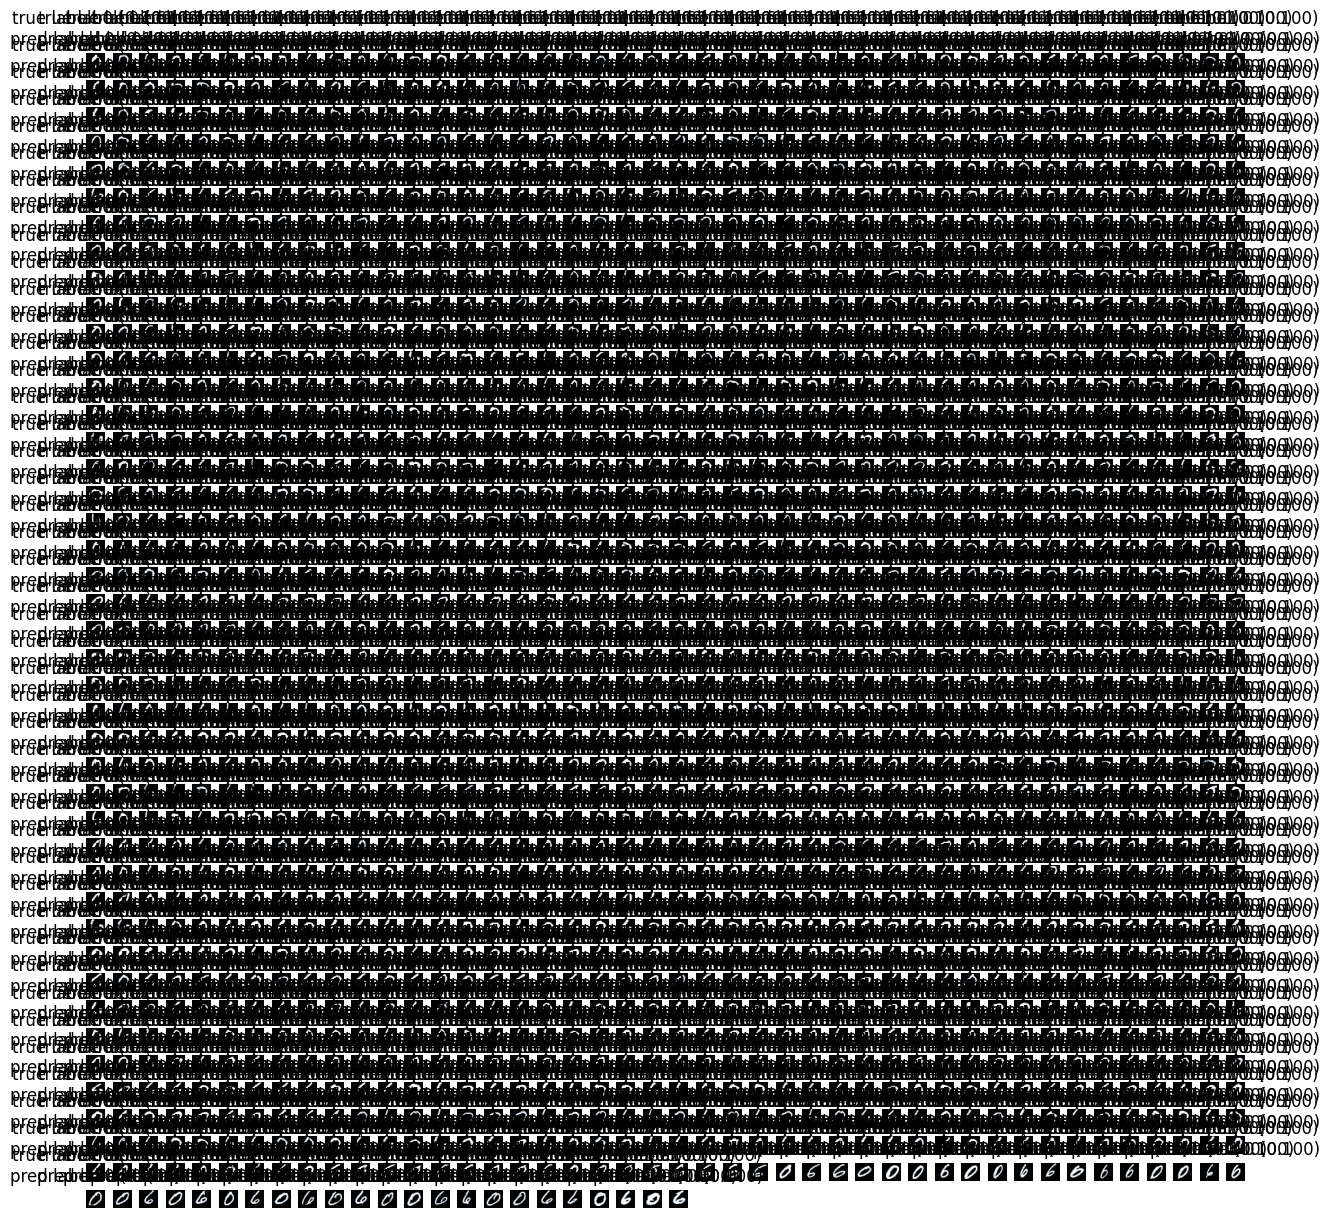

In [54]:
n_images = len(incorrect_ex)
plot_incorrect(incorrect_ex, n_images)